## AutoencoderによるAnomaly Detection

参考
- Notebook sample: [Anomaly Detection](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/anomaly-detection/anomaly_detection.ipynb)

In [1]:
import h2o
print(h2o.__version__)

3.30.0.1


In [2]:
h2o.init(url='http://54.91.22.51:54321')

Checking whether there is an H2O instance running at http://54.91.22.51:54321 . connected.


H2O_cluster_uptime:,16 mins 20 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,"1 year, 1 month and 24 days !!!"
H2O_cluster_name:,Puddle
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,49.93 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


### データ

利用データ: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

特徴量
- Time : Seconds elapsed between each transaction
- V1~V28 : Principal components obtained with PCA (秘匿情報にPCAを実施したもの)
- Amount : Transaction Amount

ターゲット
- Class : 1:Fraud, 0:Not Fraud

284,807のトランザクション中、492件のみがFraud（0.17%）の不均衡データ

In [7]:
frame = h2o.import_file("/data/my_sample/creditcard.csv")
frame.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(284807, 31)

In [8]:
type(frame)

h2o.frame.H2OFrame

[H2OFrame](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#h2oframe)

In [9]:
frame.head()

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0
0,1.19186,0.266151,0.16648,0.448154,0.0600176,-0.0823608,-0.078803,0.0851017,-0.255425,-0.166974,1.61273,1.06524,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.0690831,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.0089831,0.0147242,2.69,0
1,-1.35835,-1.34016,1.77321,0.37978,-0.503198,1.8005,0.791461,0.247676,-1.51465,0.207643,0.624501,0.0660837,0.717293,-0.165946,2.34586,-2.89008,1.10997,-0.121359,-2.26186,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.0553528,-0.0597518,378.66,0
1,-0.966272,-0.185226,1.79299,-0.863291,-0.0103089,1.2472,0.237609,0.377436,-1.38702,-0.0549519,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.05965,-0.684093,1.96578,-1.23262,-0.208038,-0.1083,0.0052736,-0.190321,-1.17558,0.647376,-0.221929,0.0627228,0.0614576,123.5,0
2,-1.15823,0.877737,1.54872,0.403034,-0.407193,0.0959215,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.34585,-1.11967,0.175121,-0.451449,-0.237033,-0.0381948,0.803487,0.408542,-0.0094307,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0
2,-0.425966,0.960523,1.14111,-0.168252,0.420987,-0.0297276,0.476201,0.260314,-0.568671,-0.371407,1.34126,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.0581328,0.0686531,-0.0331938,0.0849677,-0.208254,-0.559825,-0.0263977,-0.371427,-0.232794,0.105915,0.253844,0.0810803,3.67,0
4,1.22966,0.141004,0.0453708,1.20261,0.191881,0.272708,-0.005159,0.0812129,0.46496,-0.0992543,-1.41691,-0.153826,-0.751063,0.167372,0.0501436,-0.443587,0.00282051,-0.611987,-0.045575,-0.219633,-0.167716,-0.27071,-0.154104,-0.780055,0.750137,-0.257237,0.0345074,0.00516777,4.99,0
7,-0.644269,1.41796,1.07438,-0.492199,0.948934,0.428118,1.12063,-3.80786,0.615375,1.24938,-0.619468,0.291474,1.75796,-1.32387,0.686133,-0.076127,-1.22213,-0.358222,0.324505,-0.156742,1.94347,-1.01545,0.0575035,-0.649709,-0.415267,-0.0516343,-1.20692,-1.08534,40.8,0
7,-0.894286,0.286157,-0.113192,-0.271526,2.6696,3.72182,0.370145,0.851084,-0.392048,-0.41043,-0.705117,-0.110452,-0.286254,0.0743554,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.0527357,-0.0734251,-0.268092,-0.204233,1.01159,0.373205,-0.384157,0.0117474,0.142404,93.2,0
9,-0.338262,1.11959,1.04437,-0.222187,0.499361,-0.246761,0.651583,0.0695386,-0.736727,-0.366846,1.01761,0.83639,1.00684,-0.443523,0.150219,0.739453,-0.54098,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.38505,-0.069733,0.0941988,0.246219,0.0830756,3.68,0


In [10]:
feature_names = frame.col_names[:30]   # 特徴量カラム名（30変数）

In [11]:
frame.describe()

Rows:284807
Cols:31




,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
type,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int
mins,0.0,-56.407509631329,-72.7157275629303,-48.3255893623954,-5.68317119816995,-113.743306711146,-26.1605059358433,-43.5572415712451,-73.2167184552674,-13.4340663182301,-24.5882624372475,-4.79747346479757,-18.6837146333443,-5.79188120632084,-19.2143254902614,-4.49894467676621,-14.1298545174931,-25.1627993693248,-9.49874592104677,-7.21352743017759,-54.497720494566,-34.8303821448146,-10.933143697655,-44.8077352037913,-2.83662691870341,-10.2953970749851,-2.60455055280817,-22.5656793207827,-15.4300839055349,0.0,0.0
mean,94813.85957508067,1.2262548514636384e-15,3.5446429300120796e-16,-1.328442755752275e-15,2.030984597736651e-15,1.0985199711028427e-15,1.500884844239349e-15,-5.875804496596601e-16,7.66409282164774e-17,-2.324774822566481e-15,2.213006802250785e-15,1.5328185643295479e-15,-1.2134813634275587e-15,9.037242785526292e-16,1.2214647934501085e-15,4.9561133579988715e-15,1.4465975200860108e-15,-3.704311530463074e-16,1.0154922988683254e-15,1.0490227049630343e-15,6.386744018039783e-16,1.532818564329548e-16,-3.4488417697414826e-16,2.5227638871257145e-16,4.469124126623338e-15,5.364864975153418e-16,1.6908904787760325e-15,-3.6434378765411323e-16,-1.241423368506483e-16,88.34961925093133,0.001727485630620034
maxs,172792.0,2.45492999121121,22.0577289904909,9.38255843282114,16.8753440335975,34.8016658766686,73.3016255459646,120.589493945238,20.0072083651213,15.5949946071278,23.7451361206545,12.0189131816199,7.8483920756446,7.12688295859376,10.5267660517847,8.87774159774277,17.3151115176278,9.25352625047285,5.04106918541184,5.59197142733558,39.4209042482199,27.2028391573154,10.5030900899454,22.5284116897749,4.58454913689817,7.51958867870916,3.5173456116238,31.6121981061363,33.8478078188831,25691.16,1.0
sigma,47488.14595456615,1.958695803857486,1.6513085794769975,1.5162550051777715,1.4158685749409203,1.3802467340314393,1.3322710897575754,1.237093598182666,1.1943529026692037,1.098632089224319,1.088849765402517,1.0207130277115584,0.9992013895301448,0.9952742301251534,0.958595611257064,0.9153160116104392,0.8762528873883701,0.8493370636743892,0.8381762095288414,0.8140405007685786,0.7709250248871169,0.7345240143713132,0.7257015604409116,0.6244602955949902,0.6056470678271602,0.5212780705409424,0.48222701326105727,0.4036324949650307,0.3300832641602509,250.12010924018855,0.041527189635465055
zeros,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1825,284315
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,0.0
1,0.0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0.0
2,1.0,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459

In [12]:
frame.isna().any()

# 欠損なし

False

In [13]:
# Fraudの数
frame['Class'].sum()

492.0

In [14]:
# Fraudの割合
frame['Class'].sum() / frame.nrows

0.001727485630620034

### Autoencoderによる異常検知

Steps:  
1. 学習データ/テストデータ分割. 学習データは異常なし（Class=0）のデータのみ
2. 学習データを用いてモデルを作成し、テストデータの異常（Class=1）をどの程度検出できるかを確認

In [21]:
import numpy as np

In [82]:
## 学習データ/テストデータ分割（学習データには異常（Class=1）を含めない）
frame['row_id'] = h2o.H2OFrame.from_python(np.arange(frame.nrow))   # 行IDの付与
frame_train, _ = frame[frame['Class'] == 0].split_frame(ratios=[.5])   # Class=0となるデータから学習データを抽出（５割）

train_id_set = set(frame_train['row_id'].as_data_frame()['row_id'])    # 学習データの行ID(set)
all_id_set = set(frame['row_id'].as_data_frame()['row_id'])
test_id_set = all_id_set - train_id_set     # テストデータとする行ID(set)
test_id_list = list(test_id_set)
test_id_list.sort()      # テストデータとする行ID(ソート済みlist)

frame_test_id = h2o.H2OFrame.from_python(test_id_list)    # テストデータとする行IDでH2OFrameを作成
frame_test_id.col_names = ['row_id']

frame_test = frame_test_id.merge(frame, all_x=True, all_y=False, by_x=['row_id'], by_y=['row_id'])   # テストデータH2OFrameを基準として元データをマージ、テストデータを抽出

print(frame.shape)                # 元データ(行ID付与)
print(frame_train.shape)      # 学習データ
print(frame_test.shape)       # テストデータ

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(284807, 32)
(142095, 32)
(142712, 32)


Python API: [H2OAutoEncoderEstimator](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oautoencoderestimator)

In [83]:
from h2o.estimators import H2OAutoEncoderEstimator

In [84]:
mod_ae = H2OAutoEncoderEstimator()

In [85]:
mod_ae.train(training_frame=frame_train, x=feature_names)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [86]:
mod_ae

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1622151212896_1


Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 52,430 weights/biases, 626.7 KB, 999,709 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,30,Input,0,,,,,,,,,
1,,2,200,Rectifier,0,0,0,3.79277e-08,3.94133e-08,0,-0.622946,2.04085,55.0816,43.621
2,,3,200,Rectifier,0,0,0,0.0223452,0.137629,0,3.00278,4.52551,1.1004,0.17017
3,,4,30,Rectifier,,0,0,0.0342946,0.14781,0,117.406,3104.27,-0.0375626,0.0777803




ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.004514370109974424
RMSE: 0.06718906242815435

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
0,,2021-05-27 22:42:19,0.535 sec,0.00000 obs/sec,0.000000,0,0.0,7.763189e-01,6.026711e-01
1,,2021-05-27 22:42:26,7.851 sec,13794 obs/sec,0.703037,1,99898.0,6.718906e-02,4.514370e-03
2,,2021-05-27 22:42:34,14.939 sec,14011 obs/sec,1.406566,2,199866.0,6.718906e-02,4.514370e-03
3,,2021-05-27 22:42:41,22.041 sec,14078 obs/sec,2.110743,3,299926.0,6.147809e+02,3.779555e+05
4,,2021-05-27 22:42:48,29.034 sec,14159 obs/sec,2.813547,4,399791.0,3.339522e+05,1.115241e+11
5,,2021-05-27 22:42:55,36.153 sec,14156 obs/sec,3.515937,5,499597.0,2.063102e+05,4.256390e+10
6,,2021-05-27 22:43:02,43.245 sec,14170 obs/sec,4.220296,6,599683.0,1.729509e+04,2.991203e+08
7,,2021-05-27 22:43:09,50.353 sec,14175 obs/sec,4.924389,7,699731.0,8.814050e+05,7.768748e+11
8,,2021-05-27 22:43:16,57.470 sec,14174 obs/sec,5.627432,8,799630.0,3.730930e+05,1.391984e+11
9,,2021-05-27 22:43:23,1 min 4.495 sec,14195 obs/sec,6.331138,9,899623.0,1.557037e+06,2.424364e+12



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,V13,1.000000,1.000000,0.248136
1,V12,0.659007,0.659007,0.163524
2,Time,0.563160,0.563160,0.139740
3,V9,0.313894,0.313894,0.077888
4,V17,0.233747,0.233747,0.058001
5,V11,0.219663,0.219663,0.054506
6,V3,0.155951,0.155951,0.038697
7,V15,0.121596,0.121596,0.030172
8,V14,0.101213,0.101213,0.025114
9,V22,0.069226,0.069226,0.017178



See the whole table with table.as_data_frame()


In [87]:
# テストデータに対するスコアリング
mod_ae.predict(frame_test).head(5)

# predictを実行すると、出力層からのアウトプット（入力値の再現）となる

deeplearning prediction progress: |███████████████████████████████████████| 100%


reconstr_Time,reconstr_V1,reconstr_V2,reconstr_V3,reconstr_V4,reconstr_V5,reconstr_V6,reconstr_V7,reconstr_V8,reconstr_V9,reconstr_V10,reconstr_V11,reconstr_V12,reconstr_V13,reconstr_V14,reconstr_V15,reconstr_V16,reconstr_V17,reconstr_V18,reconstr_V19,reconstr_V20,reconstr_V21,reconstr_V22,reconstr_V23,reconstr_V24,reconstr_V25,reconstr_V26,reconstr_V27,reconstr_V28,reconstr_Amount
94849.2,0.00143575,-0.00939289,0.0125407,-0.00797958,0.00222789,-0.000220878,0.011912,0.00095934,0.00232677,0.0121638,-0.00780876,0.0106712,-0.000279038,0.0111553,0.000760643,0.0066476,0.0105607,0.00491656,-0.000789295,-0.00137839,-0.00146105,-0.000734427,0.000284731,-0.00023273,-0.000523288,-0.000655138,0.00041127,-0.00085649,89.0945
94849.2,0.00143575,-0.00939289,0.0125407,-0.00797958,0.00222789,-0.000220878,0.011912,0.00095934,0.00232677,0.0121638,-0.00780876,0.0106712,-0.000279038,0.0111553,0.000760643,0.0066476,0.0105607,0.00491656,-0.000789295,-0.00137839,-0.00146105,-0.000734427,0.000284731,-0.00023273,-0.000523288,-0.000655138,0.00041127,-0.00085649,89.0945
94849.2,0.00143575,-0.00939289,0.0125407,-0.00797958,0.00222789,-0.000220878,0.011912,0.00095934,0.00232677,0.0121638,-0.00780876,0.0106712,-0.000279038,0.0111553,0.000760643,0.0066476,0.0105607,0.00491656,-0.000789295,-0.00137839,-0.00146105,-0.000734427,0.000284731,-0.00023273,-0.000523288,-0.000655138,0.00041127,-0.00085649,89.0945
94849.2,0.00143575,-0.00939289,0.0125407,-0.00797958,0.00222789,-0.000220878,0.011912,0.00095934,0.00232677,0.0121638,-0.00780876,0.0106712,-0.000279038,0.0111553,0.000760643,0.0066476,0.0105607,0.00491656,-0.000789295,-0.00137839,-0.00146105,-0.000734427,0.000284731,-0.00023273,-0.000523288,-0.000655138,0.00041127,-0.00085649,89.0945
94849.2,0.00143575,-0.00939289,0.0125407,-0.00797958,0.00222789,-0.000220878,0.011912,0.00095934,0.00232677,0.0121638,-0.00780876,0.0106712,-0.000279038,0.0111553,0.000760643,0.0066476,0.0105607,0.00491656,-0.000789295,-0.00137839,-0.00146105,-0.000734427,0.000284731,-0.00023273,-0.000523288,-0.000655138,0.00041127,-0.00085649,89.0945


In [88]:
# テストデータに対するスコアリング. 異常値スコア（MSE）を取得する場合
score_ae = mod_ae.anomaly(frame_test)
score_ae.head()

Reconstruction.MSE
0.0108852
0.0129889
0.0112734
0.0119371
0.0113892
0.0108481
0.0109746
0.011719
0.0110519
0.0143791


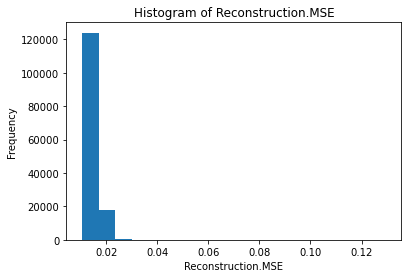

In [89]:
score_ae.hist()

In [90]:
score_ae.quantile()

Probs,Reconstruction.MSEQuantiles
0.01,0.000950836
0.1,0.00177806
0.25,0.00261492
0.333,0.00305987
0.5,0.00401314
0.667,0.00511695
0.75,0.00575289
0.9,0.0076552
0.99,0.0129255


### 精度検証

In [98]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
# pandas.DataFrameへ変換（ローカル環境上のオブジェクトにロード）
df_res = pd.concat([frame_test['Class'].as_data_frame(), score_ae['Reconstruction.MSE'].as_data_frame()], axis=1)
df_res

,Class,Reconstruction.MSE
0,0,0.010885
1,0,0.012989
2,0,0.011273
3,0,0.011937
4,0,0.011389
...,...,...
142707,0,0.009835
142708,0,0.007460
142709,0,0.007310
142710,0,0.014286


In [96]:
actual = df_res['Class']   # 実測
anomaly_score = df_res['Reconstruction.MSE']  # 予測

[]

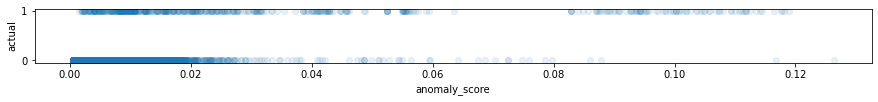

In [99]:
# 予実プロット
plt.figure(figsize=[15,1])
plt.scatter(anomaly_score, actual, alpha=0.1)
plt.xlabel('anomaly_score')
plt.ylabel('actual')
plt.plot()

#### ROC曲線

In [100]:
fpr, tpr, threshold = roc_curve(actual, anomaly_score)

In [101]:
# AUC
auc_value = auc(fpr, tpr)
auc_value

0.9220050551475842

[]

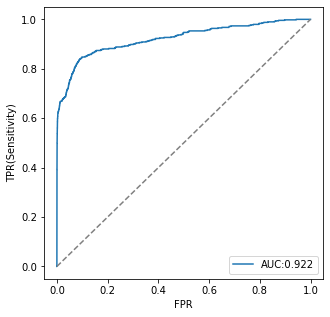

In [102]:
# ROC曲線
plt.figure(figsize=[5,5])
plt.plot(fpr, tpr, label="AUC:{:.3f}".format(auc_value))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--', color='gray')    # 斜め４５度線
plt.xlabel('FPR')
plt.ylabel('TPR(Sensitivity)')
plt.legend(loc='lower right')
plt.plot()

**True Positive Rate (Sensitivity):** 実際に1のものを、1と予測できた割合  
**False Positive Rate:** 実際は0のものを、1と予測してしまった割合

#### Precision-Recall曲線
True Negative（0を0と予測）を考慮しないので、不均衡データに対して妥当なモデル評価方法となる

In [103]:
precision, tpr, threshold = precision_recall_curve(actual, anomaly_score)

In [104]:
pd.DataFrame({'precision':precision, 'tpr':tpr, 'threshold':[0, *threshold]})

# threshold=1において、precision=1と設定されているため、値が飛んでいるようになっていると考えられる

,precision,tpr,threshold
0,0.003654,1.000000,0.000000
1,0.003646,0.997967,0.001471
2,0.003646,0.997967,0.001471
3,0.003646,0.997967,0.001471
4,0.003646,0.997967,0.001471
...,...,...,...
134356,0.750000,0.006098,0.117545
134357,0.666667,0.004065,0.117838
134358,0.500000,0.002033,0.118086
134359,0.000000,0.000000,0.118955


In [105]:
# AUCPR
aucpr_score = np.trapz(y=precision, x=tpr)*-1     # x=tprが降順になっているので符号を入れ替える
aucpr_score

0.49409228087624996

[]

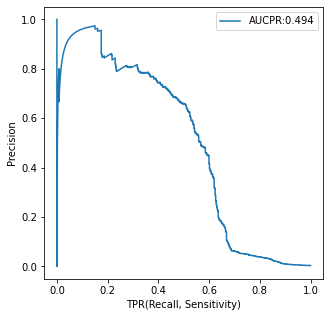

In [106]:
# Precision-Recall曲線
plt.figure(figsize=[5,5])
plt.plot(tpr, precision, label="AUCPR:{:.3f}".format(aucpr_score))
plt.xlabel('TPR(Recall, Sensitivity)')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.plot()

**Precision:** 1と予測して、実際に1だった割合  
**True Positive Rate (Recall, Sensitivity):** 実際に1のものを、1と予測できた割合

### モデルの解釈

代理モデル/Surrogate Model（予測値を目的変数とし、元の特徴量で予測、どの特徴量が効いているかを確認）を用いた解釈

In [109]:
score_ae_train = mod_ae.anomaly(frame_train)   # 学習データに対するスコアリング. 異常値スコア（MSE）を取得
frame_train['anomaly_score'] = score_ae_train    #異常値スコアを学習データに結合
frame_train.head(5)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,row_id,anomaly_score
0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0,0,0.0111147
1,-1.35835,-1.34016,1.77321,0.37978,-0.503198,1.8005,0.791461,0.247676,-1.51465,0.207643,0.624501,0.0660837,0.717293,-0.165946,2.34586,-2.89008,1.10997,-0.121359,-2.26186,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.0553528,-0.0597518,378.66,0,2,0.0133995
2,-1.15823,0.877737,1.54872,0.403034,-0.407193,0.0959215,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.34585,-1.11967,0.175121,-0.451449,-0.237033,-0.0381948,0.803487,0.408542,-0.0094307,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0,4,0.0112982
2,-0.425966,0.960523,1.14111,-0.168252,0.420987,-0.0297276,0.476201,0.260314,-0.568671,-0.371407,1.34126,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.0581328,0.0686531,-0.0331938,0.0849677,-0.208254,-0.559825,-0.0263977,-0.371427,-0.232794,0.105915,0.253844,0.0810803,3.67,0,5,0.0106175
7,-0.894286,0.286157,-0.113192,-0.271526,2.6696,3.72182,0.370145,0.851084,-0.392048,-0.41043,-0.705117,-0.110452,-0.286254,0.0743554,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.0527357,-0.0734251,-0.268092,-0.204233,1.01159,0.373205,-0.384157,0.0117474,0.142404,93.2,0,8,0.0111183


#### GLM
[Python API](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogeneralizedlinearestimator)

In [110]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [111]:
surrogate_glm = H2OGeneralizedLinearEstimator(lambda_=0)  # lambda_=0: 正則化を実施しない

In [112]:
surrogate_glm.train(training_frame=frame_train, x=feature_names, y='anomaly_score')

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [113]:
surrogate_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1622151212896_3


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,None,30,30,1,py_53_sid_8122




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 5.873457641031779e-06
RMSE: 0.002423521743461729
MAE: 0.0018324950718769477
RMSLE: 0.0023874001880709594
R^2: 0.28415345013445203
Mean Residual Deviance: 5.873457641031779e-06
Null degrees of freedom: 142094
Residual degrees of freedom: 142064
Null deviance: 1.1658769098756683
Residual deviance: 0.8345889635024106
AIC: -1308231.6623647618

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2021-05-27 23:00:12,0.000 sec,0,1.165877,0.000008


代理モデルの当てはまりは、R2で見た場合28% （低い）

In [114]:
# 回帰係数の取得
# surrogate_glm.coef_norm()  ->  標準化された特徴量に対する回帰係数の推定結果
df_coeff = pd.DataFrame.from_dict(surrogate_glm.coef_norm(), orient='index').reset_index()
df_coeff.columns = ['Feature', 'Coeff']
df_coeff = df_coeff.drop(0, axis=0)   # Interceptを削除
df_coeff.head()

,Feature,Coeff
1,Time,-0.000040
2,V1,-0.000919
3,V2,-0.000082
4,V3,-0.000694
5,V4,0.000427


[]

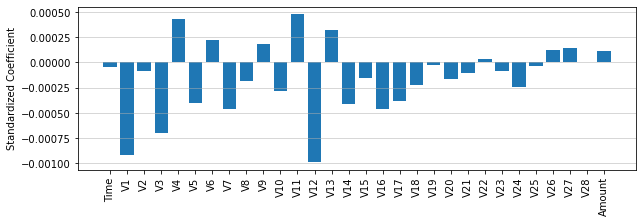

In [115]:
plt.figure(figsize=[10,3])
plt.bar(df_coeff['Feature'], df_coeff['Coeff'])
plt.xticks(rotation=90)
plt.ylabel('Standardized Coefficient')
plt.grid(linewidth=0.5, axis='y')
plt.plot()